# **Week 1**

## **Team 3**
- Shinto Machado
- Adrián García
- Gerard Asbert
- Kunal Purkayastha

# **Introduction and Hypothesis**

In this notebook we build and analyse a Bag of Visual Words (BoVW) pipeline for image classification.  
The main goal is to understand the role of each component of the pipeline and to identify a good overall configuration by changing one parameter at a time.

**Hypothesis:** Our hypothesis is...

# Imports

In [10]:
from bovw import BOVW
from main import Dataset, train, test

from typing import *
from PIL import Image

import numpy as np
import glob
import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold   

# 1. Load dataset, prepare cross validation (3-Fold) and basic pipeline

In [11]:
data_train = Dataset(ImageFolder="../places_reduced/train")
data_val   = Dataset(ImageFolder="../places_reduced/val")
data = data_train + data_val

kfold = KFold(n_splits=3, shuffle=True, random_state=20)

accuracies = []

In [12]:
for fold, (train_idx, test_idx) in enumerate(kfold.split(data), start=1):
    print(f"\n========== Fold {fold} ==========")
    train_data = [data[i] for i in train_idx]
    test_data  = [data[i] for i in test_idx]

    bovw = BOVW()
    bovw, classifier = train(dataset=train_data, bovw=bovw)

    acc = test(dataset=test_data, bovw=bovw, classifier=classifier)
    accuracies.append(acc)

print("\n========== 3-Fold Cross-Validation ==========")
print("Accuracies per fold:", accuracies)
print("Average accuracy:", np.mean(accuracies))


========== Fold 1 ==========


Phase [Training]: Extracting the descriptors:   0%|          | 0/7266 [00:00<?, ?it/s]

Phase [Training]: Extracting the descriptors:  51%|█████     | 3691/7266 [00:17<00:16, 216.10it/s]


KeyboardInterrupt: 

# 2. Different Descriptors (Sift, orb, Akaze and Dense SIFT)

In [11]:
detector_types = ['DENSE_SIFT', 'SIFT', 'ORB', 'AKAZE']

results = {}

for det in detector_types:
    print(f"\n\n###############################")
    print(f"### Descriptor: {det}")
    print(f"###############################")

    kfold = KFold(n_splits=3, shuffle=True, random_state=42)

    accuracies = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(data), start=1):
        print(f"\n========== Fold {fold} ==========")
        train_data = [data[i] for i in train_idx]
        test_data  = [data[i] for i in test_idx]

        # Usar el descriptor correspondiente
        bovw = BOVW(detector_type=det)
        bovw, classifier = train(dataset=train_data, bovw=bovw)

        acc = test(dataset=test_data, bovw=bovw, classifier=classifier)
        accuracies.append(acc)

    print("\n========== 3-Fold Cross-Validation ==========")
    print("Accuracies per fold:", accuracies)
    print("Average accuracy:", np.mean(accuracies))

    results[det] = {
        "fold_accuracies": accuracies,
        "mean_accuracy": np.mean(accuracies)
    }

print("\n\n===== Summary over descriptors =====")
for det in detector_types:
    print(f"{det}: mean accuracy = {results[det]['mean_accuracy']:.4f}")




###############################
### Descriptor: DENSE_SIFT
###############################

========== Fold 1 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7266/7266 [04:04<00:00, 29.66it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3285163776493256


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3634/3634 [01:58<00:00, 30.78it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.3148046230049532

========== Fold 2 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7267/7267 [08:01<00:00, 15.10it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3343883308105133


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3633/3633 [03:31<00:00, 17.20it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.3118634737131847

========== Fold 3 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7267/7267 [07:56<00:00, 15.24it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3590202284298885


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3633/3633 [03:29<00:00, 17.36it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.31516652903936143

========== 3-Fold Cross-Validation ==========
Accuracies per fold: [0.3148046230049532, 0.3118634737131847, 0.31516652903936143]
Average accuracy: 0.3139448752524998


###############################
### Descriptor: SIFT
###############################

========== Fold 1 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7266/7266 [03:00<00:00, 40.15it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3243875584916047


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3634/3634 [01:05<00:00, 55.14it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.2935022026431718

========== Fold 2 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7267/7267 [02:53<00:00, 41.92it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3121816930488644


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3633/3633 [01:20<00:00, 45.10it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.29975227085053674

========== Fold 3 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7267/7267 [03:34<00:00, 33.94it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.31369580178940126


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3633/3633 [01:21<00:00, 44.33it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.2992017616295073

========== 3-Fold Cross-Validation ==========
Accuracies per fold: [0.2935022026431718, 0.29975227085053674, 0.2992017616295073]
Average accuracy: 0.2974854117077386


###############################
### Descriptor: ORB
###############################

========== Fold 1 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7266/7266 [00:15<00:00, 480.65it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.19655884377150723


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3634/3634 [00:07<00:00, 465.13it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.17400881057268722

========== Fold 2 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7267/7267 [00:15<00:00, 468.85it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.20412938747419132


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3633/3633 [00:07<00:00, 470.18it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.1770374449339207

========== Fold 3 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7267/7267 [00:15<00:00, 474.28it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.19465859030837004


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3633/3633 [00:07<00:00, 468.61it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.1717588769611891

========== 3-Fold Cross-Validation ==========
Accuracies per fold: [0.17400881057268722, 0.1770374449339207, 0.1717588769611891]
Average accuracy: 0.17426837748926569


###############################
### Descriptor: AKAZE
###############################

========== Fold 1 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7266/7266 [01:11<00:00, 101.81it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.20774744968293354


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3634/3634 [00:38<00:00, 94.24it/s] 


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.19652701212789417

========== Fold 2 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7267/7267 [01:11<00:00, 101.27it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.21030871003307608


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3633/3633 [00:38<00:00, 93.53it/s] 


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.18891340319911748

========== Fold 3 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7267/7267 [01:12<00:00, 100.58it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.22249793217535152


Phase [Eval]: Extracting the descriptors: 100%|██████████| 3633/3633 [00:39<00:00, 92.91it/s] 


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.18936052921719956

========== 3-Fold Cross-Validation ==========
Accuracies per fold: [0.19652701212789417, 0.18891340319911748, 0.18936052921719956]
Average accuracy: 0.1916003148480704


===== Summary over descriptors =====
DENSE_SIFT: mean accuracy = 0.3139
SIFT: mean accuracy = 0.2975
ORB: mean accuracy = 0.1743
AKAZE: mean accuracy = 0.1916


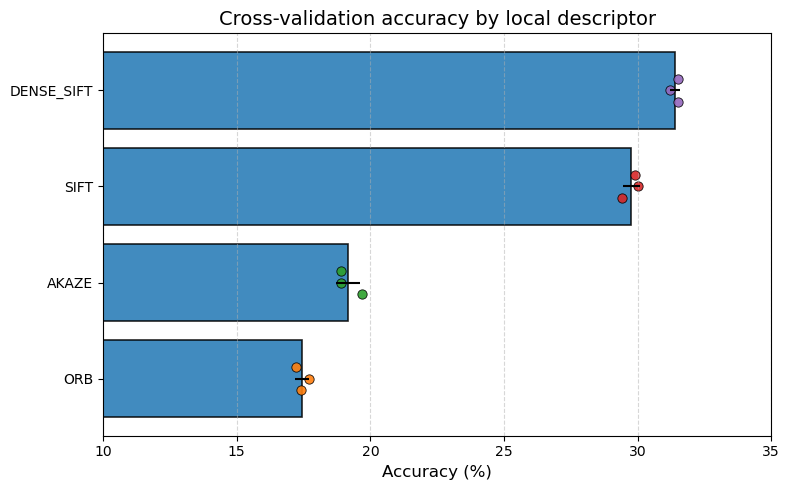

In [8]:


# Cross-val w/ 3 folds accuracy, obtained from the previous experiment using default values for each Local descriptor
data = {
    'Method': ['AKAZE', 'AKAZE', 'AKAZE', 
               'ORB', 'ORB', 'ORB',
               'SIFT', 'SIFT', 'SIFT',
               'DENSE_SIFT', 'DENSE_SIFT', 'DENSE_SIFT'],
    'Accuracy': [
        19.7, 18.9, 18.9,   # AKAZE: 0.1965, 0.1889, 0.1893
        17.4, 17.7, 17.2,   # ORB:   0.1740, 0.1770, 0.1717
        29.4, 30.0, 29.9,   # SIFT:  0.2935, 0.2997, 0.2992
        31.5, 31.2, 31.5    # DENSE_SIFT: 0.3148, 0.3118, 0.3151
    ]
}

df = pd.DataFrame(data)

# Resumen por método: media y desviación típica
summary = (
    df.groupby('Method')['Accuracy']
      .agg(['mean', 'std'])
      .reset_index()
      .sort_values('mean')  # orden de menor a mayor
)

fig, ax = plt.subplots(figsize=(8, 5))

y_pos = np.arange(len(summary))

# Barras horizontales con barras de error (std)
ax.barh(
    y_pos,
    summary['mean'],
    xerr=summary['std'],
    align='center',
    alpha=0.85,
    linewidth=1.2,
    edgecolor='black'
)

# Puntos individuales de cada fold (para que se vea la dispersión)
for i, method in enumerate(summary['Method']):
    xs = df[df['Method'] == method]['Accuracy'].values
    # pequeño jitter vertical para que no se solapen exactamente
    jitter = np.linspace(-0.12, 0.12, len(xs))
    ax.scatter(
        xs,
        np.full_like(xs, y_pos[i], dtype=float) + jitter,
        s=45,
        edgecolor='black',
        linewidth=0.6,
        alpha=0.9
    )

ax.set_yticks(y_pos)
ax.set_yticklabels(summary['Method'])
ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_title('Cross-validation accuracy by local descriptor', fontsize=14)

ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_xlim(10, 35)

plt.tight_layout()
plt.show()

## 2.1 Dense Sift with tiny steps and different scales

In [ ]:

#Numerical results

In [ ]:

#Plots and visual results

# 3. Different amount of local features

In [ ]:

#Numerical results

In [ ]:

#Plots and visual results

# 4. Different Codebook sizes k (10, 100, 1000, ... )

In [11]:
#Numerical results

codebook_sizes = [50, 100, 200, 400]

detector_type = 'SIFT'

results = {}

for k in codebook_sizes:
    print(f"\n\n###############################")
    print(f"### Codebook size: {k}")
    print(f"###############################")

    kfold = KFold(n_splits=3, shuffle=True, random_state=42)

    accuracies = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(data), start=1):
        print(f"\n========== Fold {fold} ==========")
        train_data = [data[i] for i in train_idx]
        test_data  = [data[i] for i in test_idx]

        # Usar el descriptor correspondiente
        bovw = BOVW(detector_type=detector_type, codebook_size=k)
        bovw, classifier = train(dataset=train_data, bovw=bovw)

        acc = test(dataset=test_data, bovw=bovw, classifier=classifier)
        accuracies.append(acc)

    print("\n========== 3-Fold Cross-Validation ==========")
    print("Accuracies per fold:", accuracies)
    print("Average accuracy:", np.mean(accuracies))

    results[k] = {
        "fold_accuracies": accuracies,
        "mean_accuracy": np.mean(accuracies)
    }

print("\n\n===== Summary over codebook_sizes =====")
for k in codebook_sizes:
    print(f"{k}: mean accuracy = {results[k]['mean_accuracy']:.4f}")




###############################
### Codebook size: 50
###############################

========== Fold 1 ==========


Phase [Training]: Extracting the descriptors: 100%|██████████| 7266/7266 [02:29<00:00, 48.47it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3222742290748899


Phase [Eval]: Extracting the descriptors:  28%|██▊       | 1034/3634 [00:22<00:57, 45.52it/s]


KeyboardInterrupt: 

In [ ]:

#Plots and visual results

# 5. Different Classifiers (...)

In [ ]:

#Numerical results

In [ ]:

#Plots and visual results

# 6. Dimensionality reduction


# 7. Spatial Pyramids


# 8. Fisher Vectors


# 9. Conclusion

Our hyphothesis...
